In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import torch.optim as optim
import torch
import torch.nn as nn

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display,clear_output

import warnings
warnings.filterwarnings("ignore")

In [3]:
from dataset import HotelBookingsDataset
from experiments import Benchmarking
from utils.logger_config import setup_logger
from tqdm import tqdm
from models.wrapper import PYTORCH_MODELS

logger = setup_logger()

In [4]:
from experiments.counterfactual import *
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from models import PyTorchDNN, PyTorchLinearSVM, PyTorchRBFNet, PyTorchLogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.gaussian_process import GaussianProcessClassifier

dataset = HotelBookingsDataset()
input_dim = dataset.get_dataframe().shape[1] - 1
seed = None
# torch.manual_seed(seed)

counterfactual_algorithms = [
    'DiCE',
    'DisCount',
    # 'KNN',
]

experiment = Benchmarking(
    dataset=dataset,
    models=[
        # (GaussianProcessClassifier(),'sklearn'),
        # (PyTorchLogisticRegression(input_dim=input_dim), 'PYT'),
        (PyTorchDNN(input_dim=input_dim), 'PYT'),
        # (PyTorchRBFNet(input_dim=input_dim, hidden_dim=input_dim), 'PYT'),
        # (PyTorchLinearSVM(input_dim=input_dim), 'PYT'),
        # (RandomForestClassifier(n_estimators=10), 'sklearn'), 
        # (GradientBoostingClassifier(n_estimators=10), 'sklearn'), 
        # (AdaBoostClassifier(n_estimators=10), 'sklearn'), 
    ],
    shapley_methods=[
        # "Train_Distri",
        "CF_UniformMatch",
        # "CF_ExactMatch",
        "CF_SingleMatch",
        "CF_OTMatch",
        "CF_OTMatch_0.5", 
        # "CF_OTMatch_1.0",
        # "CF_OTMatch_5.0",
        # "CF_OTMatch_10.0",
    ],
    distance_metrics=[
        'optimal_transport',
        'mean_difference',
        'median_difference',
        # 'max_mean_discrepancy',
    ]
)

experiment.train_and_evaluate_models(random_state=seed)
experiment.models_performance()

logger.info("\n\n------Compute Counterfactuals------")
sample_num = 50
model_counterfactuals = {}
for model, model_name in zip(experiment.models, experiment.model_names):
    model_counterfactuals[model_name] = {}

    for algorithm in counterfactual_algorithms:
        if algorithm == 'DisCount' and model_name not in PYTORCH_MODELS:
            logger.info(f'Skipping {algorithm} for {model_name} due to incompatability')
            continue
        logger.info(f'Computing {model_name} counterfactuals with {algorithm}')
        function_name = f"compute_{algorithm}_counterfactuals"
        try:
            func = globals()[function_name]
            model_counterfactuals[model_name][algorithm] = func(
                experiment.X_test,
                model = model,
                target_name = experiment.dataset.target_name,
                sample_num = sample_num,
                experiment=experiment,
            )
        except KeyError:
            print(f"Function {function_name} is not defined.")


INFO:root:PyTorchDNN accuracy: 0.8420861602032554
INFO:root:

------Compute Counterfactuals------
INFO:root:Computing PyTorchDNN counterfactuals with DiCE
100%|██████████| 50/50 [01:21<00:00,  1.63s/it]
INFO:root:Computing PyTorchDNN counterfactuals with DisCount
INFO:root:Optimization started
INFO:root:U_1-Qu_upper=0.4, U_2-Qv_upper=-0.5905936185427838
INFO:root:eta=1, l=0.24000000000000002, r=1
INFO:root:Iter 1: Q = 0.29967260360717773, term1 = 0.19962887465953827, term2 = 0.29967260360717773
INFO:root:U_1-Qu_upper=-0.05722891176075262, U_2-Qv_upper=-0.39135396835161834
INFO:root:eta=0.9030413890800365, l=0.278, r=1
INFO:root:Iter 2: Q = 0.2416134625673294, term1 = 0.0667438954114914, term2 = 0.2603890299797058
INFO:root:U_1-Qu_upper=0.04321082259600395, U_2-Qv_upper=-0.3394120098288242
INFO:root:eta=1, l=0.31410000000000005, r=1
INFO:root:Iter 3: Q = 0.20395538210868835, term1 = 0.0742892473936081, term2 = 0.20395538210868835
INFO:root:U_1-Qu_upper=0.029577642262915038, U_2-Qv_upper

In [5]:
logger.info("\n\n------Compute Shapley Values------")
experiment.compute_shapley_values(
    model_counterfactuals=model_counterfactuals,
);

INFO:root:

------Compute Shapley Values------
INFO:root:Shapley values for PyTorchDNN using CF_UniformMatch with counterfactual by DiCE


  0%|          | 0/50 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.19876383, 0.13853237, 0.10884686, 0.09143136, 0.08020295,
       0.07256457, 0.06722894, 0.063494  , 0.06095424, 0.05937102,
       0.05860985])
INFO:shap:num_paired_subset_sizes = 12
INFO:shap:weight_left = 0.7241318315431123
C:\Users\leiyo\AppData\Roaming\Python\Python39\site-packages\shap\explainers\_kernel.py:640: DeprecationWarning: l1_reg='auto' is deprecated and in a future version the behavior will change from a conditional use of AIC to simply a fixed number of top features. Pass l1_reg='num_features(10)' to opt-in to the new default behaviour.
  warnings.warn(
INFO:shap:np.sum(w_aug) = 24.999999999999996
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = array([-0.0337252 , -0.05615638,  0.0072975 ,  0.00803587, -0.02812133,
        0.00763691,  0.02664369,  0.13370153, -0.03277459, -0.00363919,
       -0.04620769,  0.17646111, -0.10520904,  0.07687733, -0.05439342,
        0.0190966 ,  0.1780

  0%|          | 0/50 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.18573234, 0.12858393, 0.10029547, 0.08357955, 0.07267787,
       0.06512693, 0.05969968, 0.0557197 , 0.05278709, 0.05065428,
       0.04916444, 0.04821897, 0.04775975])
INFO:shap:num_paired_subset_sizes = 14
INFO:shap:weight_left = 0.7362696262939222
C:\Users\leiyo\AppData\Roaming\Python\Python39\site-packages\shap\explainers\_kernel.py:640: DeprecationWarning: l1_reg='auto' is deprecated and in a future version the behavior will change from a conditional use of AIC to simply a fixed number of top features. Pass l1_reg='num_features(10)' to opt-in to the new default behaviour.
  warnings.warn(
INFO:shap:np.sum(w_aug) = 29.0
INFO:shap:np.sum(self.kernelWeights) = 0.9999999999999994
INFO:shap:phi = array([ 0.03290735,  0.0281291 ,  0.02928308,  0.        ,  0.00616893,
        0.00430506,  0.01108431,  0.        ,  0.0026826 , -0.00985803,
        0.        ,  0.00771885, -0.02772403,  0.08261451,  0.00710926,
  

In [7]:
experiment.md_baseline = False

In [8]:
logger.info("\n\n------Evaluating Distance Performance Under Interventions------")
experiment.evaluate_distance_performance_under_interventions(
    intervention_num_list=[0, 50, 100, 150, 200, 300, 400],
    trials_num=100,
    replace=False
)

INFO:root:

------Evaluating Distance Performance Under Interventions------
INFO:root:Computing optimal_transport for (PyTorchDNN, DiCE, CF_UniformMatch)
100%|██████████| 100/100 [00:00<00:00, 173.69it/s]
INFO:root:Computing mean_difference for (PyTorchDNN, DiCE, CF_UniformMatch)
100%|██████████| 100/100 [00:00<00:00, 356.95it/s]
INFO:root:Computing median_difference for (PyTorchDNN, DiCE, CF_UniformMatch)
100%|██████████| 100/100 [00:00<00:00, 300.56it/s]
INFO:root:Computing optimal_transport for (PyTorchDNN, DiCE, CF_SingleMatch)
100%|██████████| 100/100 [00:00<00:00, 176.92it/s]
INFO:root:Computing mean_difference for (PyTorchDNN, DiCE, CF_SingleMatch)
100%|██████████| 100/100 [00:00<00:00, 329.49it/s]
INFO:root:Computing median_difference for (PyTorchDNN, DiCE, CF_SingleMatch)
100%|██████████| 100/100 [00:00<00:00, 299.72it/s]
INFO:root:Computing optimal_transport for (PyTorchDNN, DiCE, CF_OTMatch)
100%|██████████| 100/100 [00:00<00:00, 166.11it/s]
INFO:root:Computing mean_differen

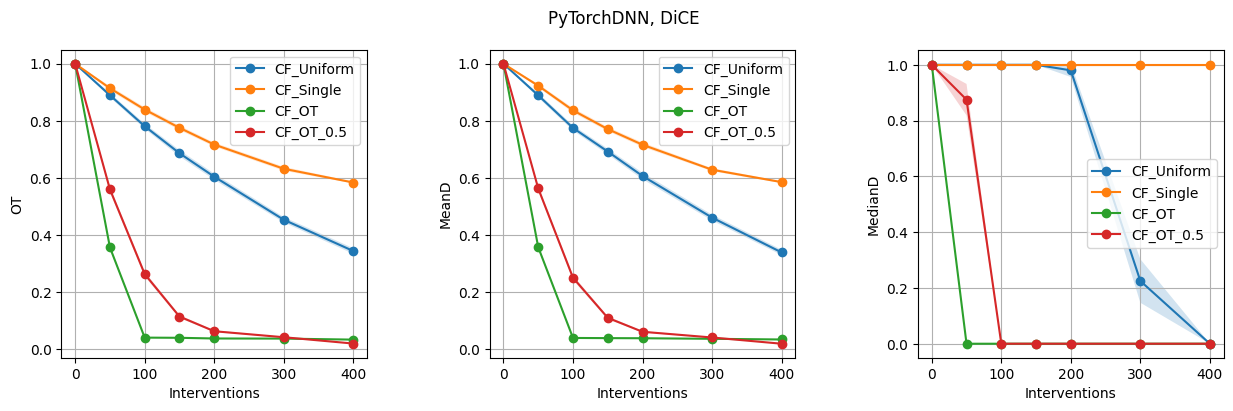

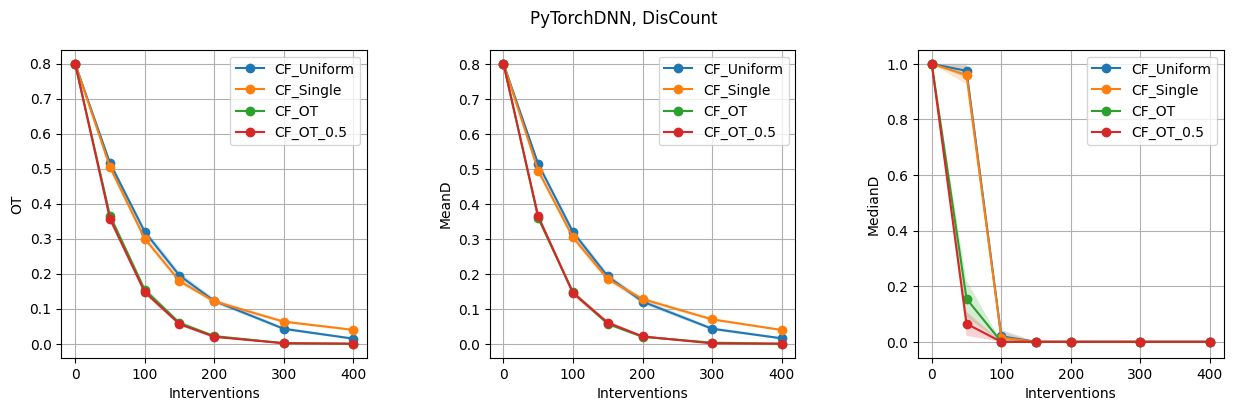

In [9]:
from experiments import plotting

plotting.intervention_vs_distance(experiment, save_to_file=False)